In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
batch_size = 32
lr = 0.0002

b1 = 0.5
b2 = 0.999

sample_interval = 25

# Создание истинных данных

In [60]:
def func_y(x):
    return np.sin(x)/x - x/10

def get_data(n):
    x = np.linspace(5, 30, n)
    y = func_y(x)
    return x, y

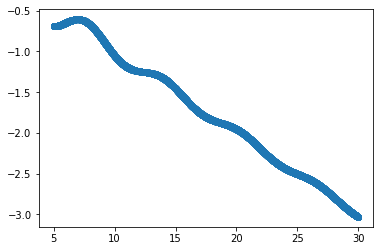

In [61]:
x_true, y_true = get_data(5000)
plt.plot(x_true, y_true, 'o')

In [9]:
class PointsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        """
        Args:
            x (np.array): x row same length as y
            y (np.array): y row same length as x

        """
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        point_x = self.x[idx]
        point_y = self.y[idx]

        return torch.tensor([point_x, point_y])


In [62]:
our_data = PointsDataset(x_true, y_true)

In [63]:
real_data = torch.utils.data.DataLoader(
    our_data,
    batch_size=batch_size,
    shuffle=True,
)

In [31]:
dataiter = iter(real_data)
print(dataiter.next())

tensor([[-18.4417,   1.8227],
        [-25.8832,   2.6147],
        [ 19.2338,  -1.9039],
        [ 18.5377,  -1.8703],
        [ -5.3951,   0.3957],
        [-23.1226,   2.2731],
        [ 10.6881,  -1.1580],
        [-20.0020,   2.0459],
        [-27.3835,   2.7667],
        [-28.5357,   2.8445],
        [ 15.7171,  -1.5723],
        [  3.7868,  -0.5375],
        [ -9.7159,   0.9420],
        [-18.3937,   1.8154],
        [  2.0464,   0.2298],
        [-14.4809,   1.5131],
        [-10.5081,   0.9667],
        [-14.5769,   1.5198],
        [ -2.6825,   0.4334],
        [ 14.8050,  -1.4275],
        [-26.6033,   2.6977],
        [-11.9484,   1.1463],
        [ 23.3987,  -2.3820],
        [ 15.3571,  -1.5133],
        [-18.5617,   1.8409],
        [ 13.1366,  -1.2726],
        [  7.8316,  -0.6555],
        [ -9.2358,   0.9439],
        [ -3.8828,   0.2144],
        [ 22.0544,  -2.2083],
        [-26.4833,   2.6852],
        [ 12.0564,  -1.2461]], dtype=torch.float64)


In [32]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x.float(), self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [83]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], 2)
        return img


In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [80]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [81]:
n_epochs = 5

d_loss_history = []
g_loss_history = []

In [82]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, elem in enumerate(real_data):

        batch_size = elem.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        elem = elem.to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, 100)))).to(device)

        #print("z ", z)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(elem)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                #sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                #display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

RuntimeError: ignored

In [78]:
gen_imgs

tensor([[ 1.0000,  0.9989],
        [ 1.0000, -1.0000],
        [ 1.0000,  1.0000],
        [ 1.0000,  0.8863],
        [ 1.0000,  0.9993],
        [ 1.0000,  0.9832],
        [ 1.0000,  1.0000],
        [ 1.0000, -1.0000]], device='cuda:0', grad_fn=<ViewBackward>)

In [52]:
gen_imgs[0].to('cpu').detach().numpy()

array([-1.,  1.], dtype=float32)

In [ ]:
gen_imgs[:,0].to('cpu').detach().numpy(), gen_imgs[:,1].to('cpu').detach().numpy(), 'o'

In [68]:
#генерация шума
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (1000, 2)))).to(device)

#print("z ", z)

# Генерируем даные Генератором на основе шума
gen_imgs = generator(z)

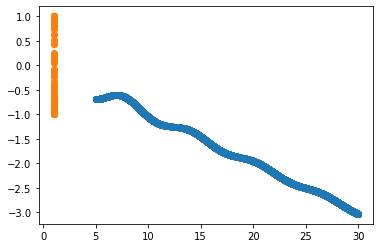

In [69]:

plt.plot(x_true, y_true, 'o', gen_imgs[:,0].to('cpu').detach().numpy(), gen_imgs[:,1].to('cpu').detach().numpy(), 'o')